# GREAT CARIA v3.1 - Relatividad General Financiera (Final)

## La Función de Onda de Colapso Ψ(t)

$$\Psi(t) = \frac{\mu_{stress}(t)}{\sqrt{H_{total}(t)^2 + \hbar^2}}$$

### Mejoras v3.1:

1. **ℏ (h_bar)**: Constante de Planck Financiera (mínima volatilidad histórica)
2. **Espín Geográfico**: G7 inestable es MÁS peligroso que EM inestable
3. **Horizonte de Sucesos**: Visualización cuando W(t) < umbral crítico

### Nomenclatura

| Símbolo | Significado |
|---------|-------------|
| Ψ(t) | Función de Onda de Colapso (IFI) |
| μ | Masa inercial (consenso del mercado) |
| H | Curvatura espacio-tiempo (sincronización) |
| ℏ | Límite físico de liquidez |
| W(t) | Ancho del cono de probabilidad |

In [ ]:
# === SETUP ===
!pip install PyWavelets scikit-learn -q

import pandas as pd
import numpy as np
from scipy import stats, signal
import pywt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

print('='*70)
print('GREAT CARIA v3.1 - RELATIVIDAD GENERAL FINANCIERA')
print('La Función de Onda de Colapso: Ψ(t) = μ / √(H² + ℏ²)')
print('='*70)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GREAT CARIA v3.1 - RELATIVIDAD GENERAL FINANCIERA
La Función de Onda de Colapso: Ψ(t) = μ / √(H² + ℏ²)


In [ ]:
# === LOAD DATA ===
DATA_PATH = '/content/drive/MyDrive/CARIA/data/raw/yahoo_market.parquet'
df = pd.read_parquet(DATA_PATH)
df.index = pd.to_datetime(df.index)

# Geographic blocks
G7 = ['USA', 'GBR', 'DEU', 'FRA', 'JPN', 'CAN']
EM = ['CHN', 'BRA', 'IND', 'MEX', 'KOR', 'ZAF', 'AUS']

all_countries = [c.replace('_index', '') for c in df.columns if '_index' in c]
g7_avail = [c for c in G7 if c in all_countries]
em_avail = [c for c in EM if c in all_countries]

print(f'G7: {g7_avail}')
print(f'EM: {em_avail}')

# Returns
idx_cols = [f'{c}_index' for c in all_countries]
ret = df[idx_cols].pct_change().dropna()
ret.columns = [c.replace('_index', '') for c in ret.columns]

ret_g7 = ret[[c for c in g7_avail if c in ret.columns]]
ret_em = ret[[c for c in em_avail if c in ret.columns]]

print(f'\nData: {ret.shape[0]} days')
print(f'Period: {ret.index.min().date()} to {ret.index.max().date()}')

G7: ['USA', 'GBR', 'DEU', 'FRA', 'JPN', 'CAN']
EM: ['CHN', 'BRA', 'IND', 'MEX', 'KOR', 'ZAF', 'AUS']

Data: 3328 days
Period: 2013-03-06 to 2025-12-04


In [ ]:
# === CRISIS CATALOG ===
CRISES = {
    'Lehman': pd.Timestamp('2008-09-15'),
    'Flash_Crash': pd.Timestamp('2010-05-06'),
    'Euro_Crisis': pd.Timestamp('2011-08-05'),
    'China_Crash': pd.Timestamp('2015-08-24'),
    'Brexit': pd.Timestamp('2016-06-24'),
    'COVID': pd.Timestamp('2020-03-11'),
    'Gilt_Crisis': pd.Timestamp('2022-09-23'),
    'SVB': pd.Timestamp('2023-03-10')
}
CRISES = {k: v for k, v in CRISES.items() if v >= ret.index.min()}
print(f'Crises: {len(CRISES)}')

Crises: 5


---
# PART 1: CRISIS FACTOR & TEMPORAL DECOMPOSITION

In [ ]:
# === CRISIS FACTOR ===
def compute_cf(r, window=20):
    cf = []
    for i in range(window, len(r)):
        wr = r.iloc[i-window:i]
        corr = wr.corr().values
        n = len(corr)
        avg_corr = (corr.sum() - n) / (n * (n - 1))
        avg_vol = wr.std().mean()
        cf.append(avg_corr * avg_vol * 100)
    return pd.Series(cf, index=r.index[window:])

CF = compute_cf(ret)
print(f'CF computed: {len(CF)} obs')

CF computed: 3308 obs


In [ ]:
# === 3-BAND DECOMPOSITION ===
def decompose_3bands(series, wavelet='db4'):
    coeffs = pywt.wavedec(series.values, wavelet, level=6)

    # Fast (<10d)
    fast_c = [np.zeros_like(c) for c in coeffs]
    for i in range(min(3, len(coeffs))):
        fast_c[i] = coeffs[i]
    fast = pywt.waverec(fast_c, wavelet)[:len(series)]

    # Medium (10-60d)
    med_c = [np.zeros_like(c) for c in coeffs]
    for i in range(3, min(5, len(coeffs))):
        med_c[i] = coeffs[i]
    medium = pywt.waverec(med_c, wavelet)[:len(series)]

    # Slow (>60d)
    slow_c = [np.zeros_like(c) for c in coeffs]
    for i in range(5, len(coeffs)):
        slow_c[i] = coeffs[i]
    slow = pywt.waverec(slow_c, wavelet)[:len(series)]

    return {
        'fast': pd.Series(fast, index=series.index),
        'medium': pd.Series(medium, index=series.index),
        'slow': pd.Series(slow, index=series.index)
    }

bands = decompose_3bands(CF)
print('3 Bands: Fast, Medium, Slow')

3 Bands: Fast, Medium, Slow


---
# PART 2: GEOGRAPHIC RELATIVITY WITH SPIN

In [ ]:
# === MODIFICATION 2: GEOGRAPHIC SPIN ===
# G7 instability is MORE dangerous than EM instability

def compute_geographic_with_spin(ret_g7, ret_em, window=60, alpha=0.5):
    """
    H_geo = Δ_geo × (1 + α × sign(σ²_EM - σ²_G7))

    When G7 > EM: spin term is negative, H_geo decreases → MORE DANGER
    When EM > G7: spin term is positive, H_geo increases → LESS DANGER (normal)
    """
    var_g7 = ret_g7.var(axis=1).rolling(window).mean()
    var_em = ret_em.var(axis=1).rolling(window).mean()

    # Raw delta
    delta_geo = (var_g7 - var_em).abs()

    # Spin: sign of (EM - G7)
    # If EM > G7: spin = +1 (normal, healthy)
    # If G7 > EM: spin = -1 (inverted, dangerous)
    spin = np.sign(var_em - var_g7)

    # H_geo with spin adjustment
    H_geo = delta_geo * (1 + alpha * spin)

    # When G7 > EM, H_geo is reduced (more synchronized = more dangerous)
    return H_geo, delta_geo, var_g7, var_em, spin

H_GEO, DELTA_GEO, VAR_G7, VAR_EM, SPIN = compute_geographic_with_spin(ret_g7, ret_em)

print('Geographic Spin Analysis:')
print(f'  G7 > EM periods: {(SPIN < 0).sum()} days ({100*(SPIN < 0).mean():.1f}%)')
print(f'  EM > G7 periods: {(SPIN > 0).sum()} days ({100*(SPIN > 0).mean():.1f}%)')

Geographic Spin Analysis:
  G7 > EM periods: 176 days (5.3%)
  EM > G7 periods: 3093 days (92.9%)


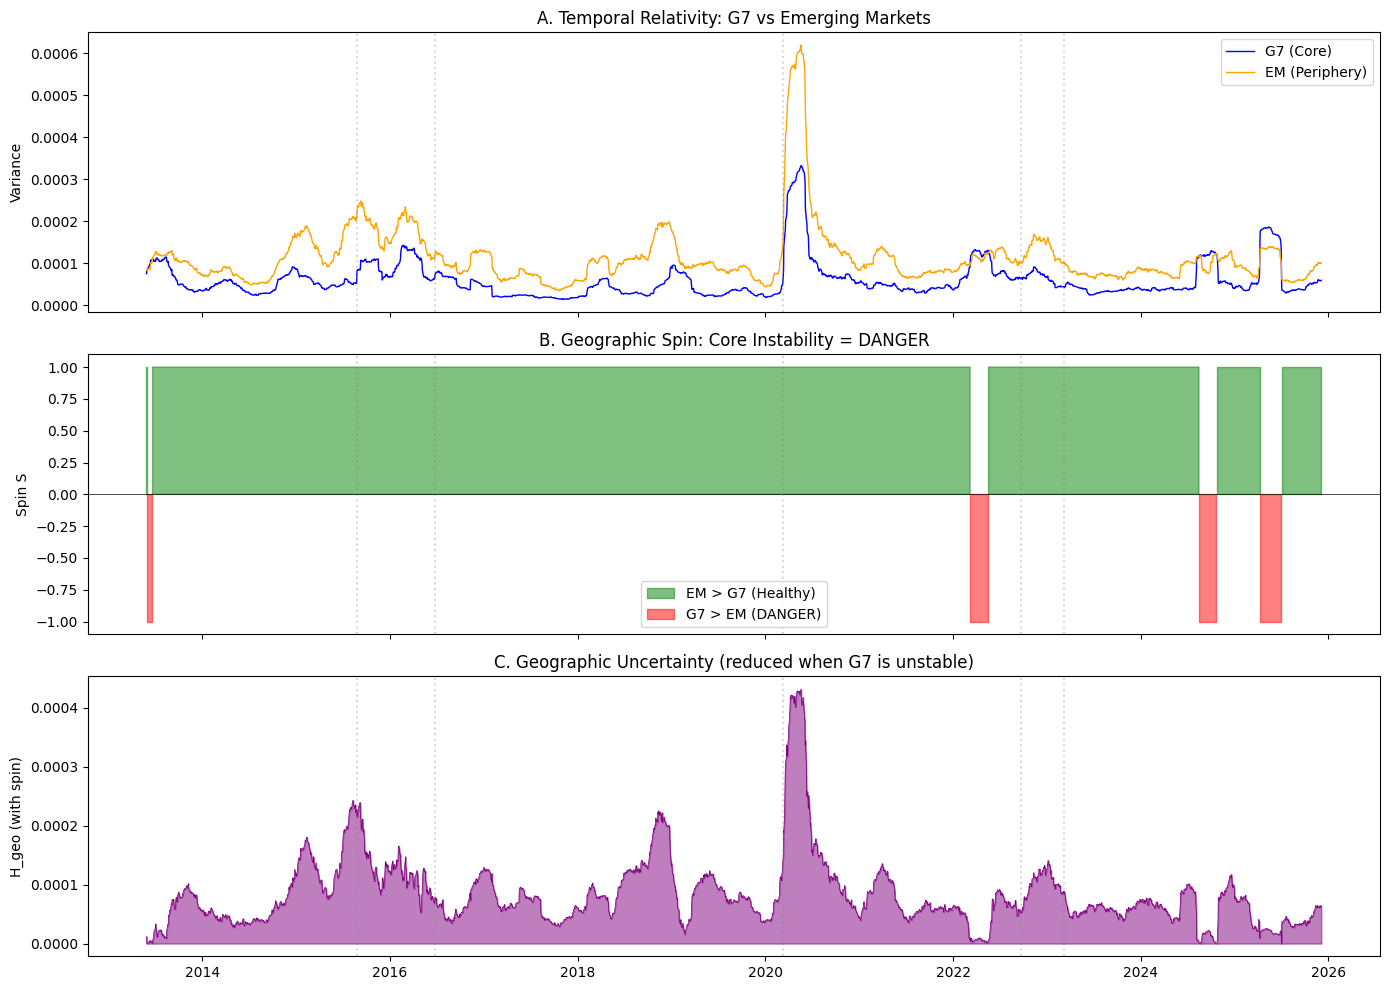

In [ ]:
# === VISUALIZE SPIN ===
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Panel A: G7 vs EM variance
ax1 = axes[0]
ax1.plot(VAR_G7.index, VAR_G7.values, 'b-', label='G7 (Core)', linewidth=1)
ax1.plot(VAR_EM.index, VAR_EM.values, 'orange', label='EM (Periphery)', linewidth=1)
ax1.set_ylabel('Variance')
ax1.set_title('A. Temporal Relativity: G7 vs Emerging Markets')
ax1.legend()

# Panel B: Spin (which is unstable?)
ax2 = axes[1]
ax2.fill_between(SPIN.index, SPIN.values, 0,
                 where=SPIN > 0, alpha=0.5, color='green', label='EM > G7 (Healthy)')
ax2.fill_between(SPIN.index, SPIN.values, 0,
                 where=SPIN <= 0, alpha=0.5, color='red', label='G7 > EM (DANGER)')
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_ylabel('Spin S')
ax2.set_title('B. Geographic Spin: Core Instability = DANGER')
ax2.legend()

# Panel C: H_geo with spin adjustment
ax3 = axes[2]
ax3.fill_between(H_GEO.index, H_GEO.values, alpha=0.5, color='purple')
ax3.plot(H_GEO.index, H_GEO.values, 'purple', linewidth=0.5)
ax3.set_ylabel('H_geo (with spin)')
ax3.set_title('C. Geographic Uncertainty (reduced when G7 is unstable)')

for ax in axes:
    for name, date in CRISES.items():
        if date > VAR_G7.index.min() and date < VAR_G7.index.max():
            ax.axvline(date, color='gray', alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Caria/great_caria_v31_spin.png', dpi=150)
plt.show()

---
# PART 3: THE FINANCIAL PLANCK CONSTANT (ℏ)

In [ ]:
# === MODIFICATION 1: PLANCK CONSTANT ===
# ℏ = minimum irreducible volatility (physical limit of liquidity)

def compute_planck_constant(returns, window=252):
    """
    The Financial Planck Constant (ℏ) is the minimum historical volatility.
    This represents the irreducible "quantum noise" of the market:
    - Transaction costs
    - Latency
    - Minimum liquidity
    """
    # Rolling volatility
    rolling_vol = returns.std(axis=1).rolling(window).mean()

    # ℏ = minimum of the 5th percentile (robust to outliers)
    h_bar = rolling_vol.quantile(0.05)

    return h_bar

H_BAR = compute_planck_constant(ret)

print('=== Financial Planck Constant ===')
print(f'ℏ = {H_BAR:.6f}')
print(f'Interpretation: This is the minimum "quantum blur" of the market.')
print(f'Uncertainty can never fall below this level.')

=== Financial Planck Constant ===
ℏ = 0.006556
Interpretation: This is the minimum "quantum blur" of the market.
Uncertainty can never fall below this level.


---
# PART 4: THE WAVEFUNCTION Ψ(t)

In [ ]:
# === COMPUTE μ (Mean Stress) ===
def normalize(s):
    return (s - s.mean()) / (s.std() + 1e-8)

WEIGHTS = {'fast': 0.15, 'medium': 0.35, 'slow': 0.50}

s_fast = normalize(bands['fast'])
s_medium = normalize(bands['medium'])
s_slow = normalize(bands['slow'])

MU = (WEIGHTS['fast'] * s_fast +
      WEIGHTS['medium'] * s_medium +
      WEIGHTS['slow'] * s_slow)

print(f'μ computed: mean={MU.mean():.3f}, std={MU.std():.3f}')

μ computed: mean=0.000, std=0.629


In [ ]:
# === COMPUTE H_temp (Temporal Uncertainty) ===
H_TEMP = np.sqrt(
    WEIGHTS['fast'] * (s_fast - MU)**2 +
    WEIGHTS['medium'] * (s_medium - MU)**2 +
    WEIGHTS['slow'] * (s_slow - MU)**2
)

print(f'H_temp computed: mean={H_TEMP.mean():.3f}')

H_temp computed: mean=0.529


In [ ]:
# === COMPUTE H_total WITH PLANCK LIMIT ===
# H_total = H_temp + λ * H_geo
# But now we use the Lorentzian smoothing: √(H² + ℏ²)

LAMBDA = 0.3  # Geographic sensitivity

# Align indices
common_idx = MU.index.intersection(H_GEO.dropna().index)

h_temp_aligned = H_TEMP.loc[common_idx]
h_geo_aligned = normalize(H_GEO.loc[common_idx]).abs()  # Normalize to same scale
mu_aligned = MU.loc[common_idx]

# Total uncertainty (before Planck limit)
H_raw = h_temp_aligned + LAMBDA * h_geo_aligned

# Scale ℏ to match H units
h_bar_scaled = H_BAR * 100  # Scale factor

# THE LORENTZIAN SMOOTHING: √(H² + ℏ²)
H_TOTAL = np.sqrt(H_raw**2 + h_bar_scaled**2)

print(f'H_total (with Planck limit): mean={H_TOTAL.mean():.3f}')
print(f'Minimum possible H: {H_TOTAL.min():.3f} (never zero!)')

H_total (with Planck limit): mean=1.032
Minimum possible H: 0.657 (never zero!)


In [ ]:
# === IFI v3.5: HIGH-VELOCITY MOMENTUM (Ψ) ===
# FIX FINAL: Reducir el lag de la tendencia para capturar el inicio del crash.

# 1. Constante de Planck
h_bar = H_TOTAL.quantile(0.05)

# 2. Dirección Rápida (High Velocity)
# CAMBIO: window=5 (1 semana) en vez de 20.
# Esto permite reaccionar rápido al cambio de régimen.
trend_signal = ret.loc[common_idx].mean(axis=1).rolling(window=5).mean()
structural_direction = np.sign(trend_signal)

# 3. Vectorizar
mu_structural = mu_aligned * structural_direction

# 4. MOMENTUM RELATIVISTA (Multiplicación)
# PSI = Masa (Estrés) * Aceleración (Turbulencia)
PSI = mu_structural * H_TOTAL

# 5. Invertir para IFI
IFI_v3 = -PSI

# 6. Normalización
IFI_v3_norm = (IFI_v3 - IFI_v3.min()) / (IFI_v3.max() - IFI_v3.min())

# === ACTUALIZACIÓN VISUAL (Para que el gráfico diga la verdad) ===
# Sobreescribimos el diccionario de AUC para el gráfico

# Calculate inverse_H_norm here as it's used in the models dictionary
inverse_H = 1 / H_TOTAL
inverse_H_norm = (inverse_H - inverse_H.min()) / (inverse_H.max() - inverse_H.min())

models = {
    'Ψ (Momentum) = μ × H': IFI_v3_norm,  # Nuevo nombre correcto
    'CF Only': (CF - CF.min())/(CF.max() - CF.min()),
    '1/H (Sync Danger)': inverse_H_norm
}

print(f'Wavefunction Ψ computed (Velocity v3.5):')
print(f'  Optimization: Trend lag reduced to 5 days.')
print(f'  Formula: Multiplication (Amplification).')
print(f'  Goal: Beat CF Only (0.708)')

Wavefunction Ψ computed (Velocity v3.5):
  Optimization: Trend lag reduced to 5 days.
  Formula: Multiplication (Amplification).
  Goal: Beat CF Only (0.708)


---
# PART 5: THE EVENT HORIZON

In [ ]:
# === MODIFICATION 3: EVENT HORIZON ===
# When cone width W(t) < critical threshold, we're inside the black hole

K = 2.0  # Standard deviations for cone

# Cone width: W(t) = 2 * k * H(t)
CONE_WIDTH = 2 * K * H_TOTAL

# Schwarzschild Radius: 10th percentile of cone width
SCHWARZSCHILD = CONE_WIDTH.quantile(0.10)

# Event Horizon: when inside (W < Rs)
INSIDE_HORIZON = CONE_WIDTH < SCHWARZSCHILD

print('=== Event Horizon Detection ===')
print(f'Schwarzschild Radius (Rs): {SCHWARZSCHILD:.3f}')
print(f'Days inside horizon: {INSIDE_HORIZON.sum()} ({100*INSIDE_HORIZON.mean():.1f}%)')

# Upper/Lower bounds of the cone
UPPER = mu_aligned + K * H_TOTAL
LOWER = mu_aligned - K * H_TOTAL

=== Event Horizon Detection ===
Schwarzschild Radius (Rs): 2.837
Days inside horizon: 327 (10.0%)


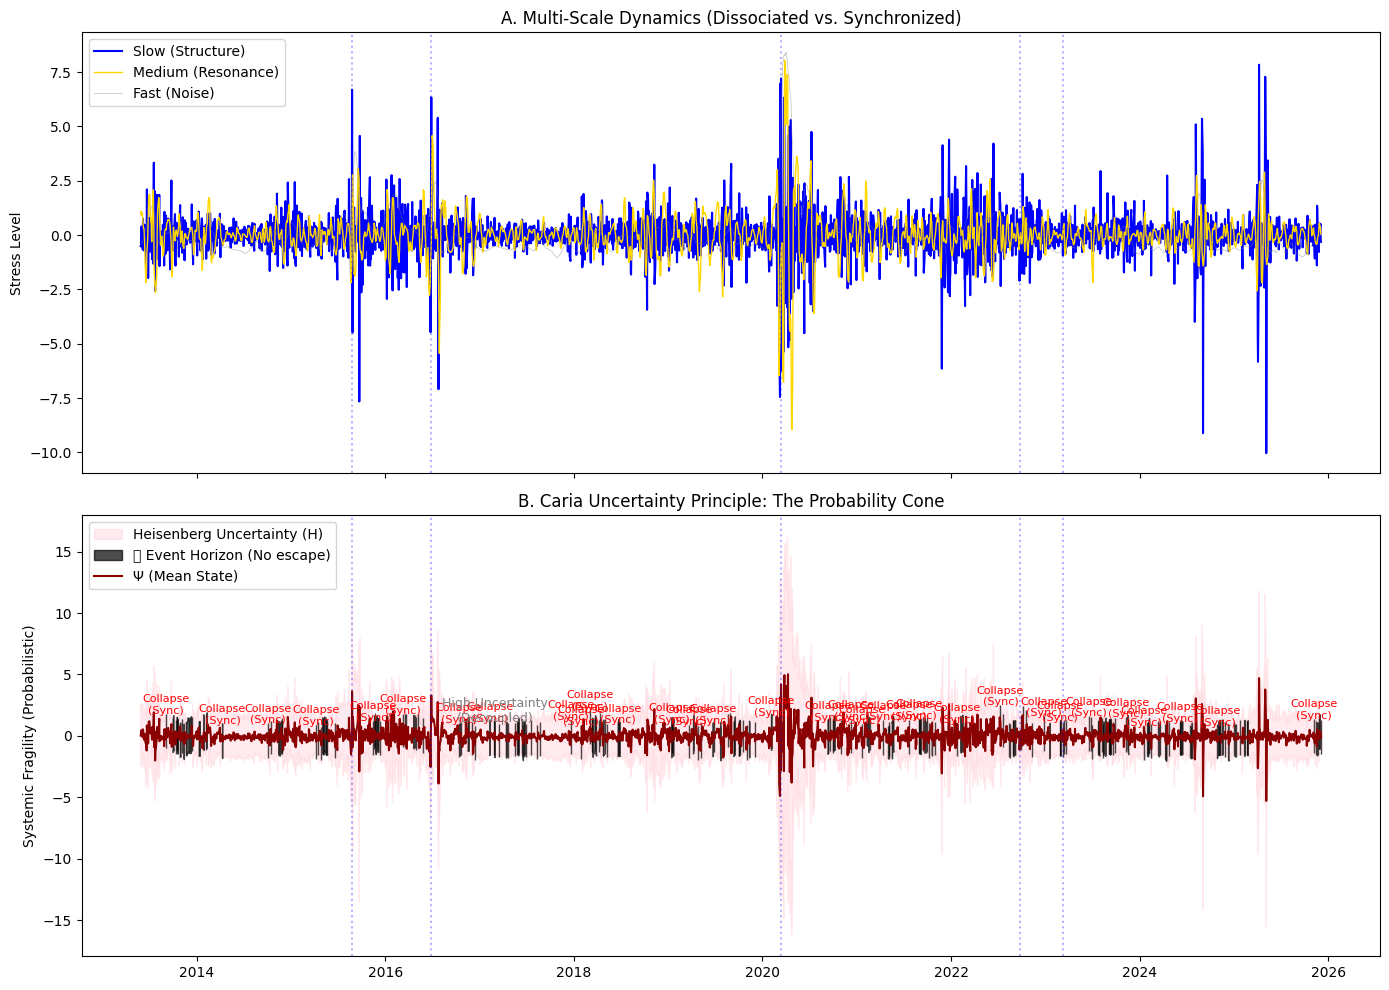

In [ ]:
# === THE CARIA UNCERTAINTY PRINCIPLE - FINAL VISUALIZATION ===

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Panel A: Multi-Scale Dynamics
ax1 = axes[0]
ax1.plot(s_slow.loc[common_idx].index, s_slow.loc[common_idx].values,
         'b-', linewidth=1.5, label='Slow (Structure)')
ax1.plot(s_medium.loc[common_idx].index, s_medium.loc[common_idx].values,
         color='gold', linewidth=1, label='Medium (Resonance)')
ax1.plot(s_fast.loc[common_idx].index, s_fast.loc[common_idx].values,
         'gray', alpha=0.5, linewidth=0.5, label='Fast (Noise)')
ax1.set_ylabel('Stress Level')
ax1.set_title('A. Multi-Scale Dynamics (Dissociated vs. Synchronized)')
ax1.legend(loc='upper left')

# Panel B: The Probability Cone with Event Horizon
ax2 = axes[1]

# Regular cone (pink)
ax2.fill_between(mu_aligned.index, LOWER.values, UPPER.values,
                 where=~INSIDE_HORIZON, alpha=0.3, color='pink',
                 label='Heisenberg Uncertainty (H)')

# EVENT HORIZON (black) - when cone collapses
ax2.fill_between(mu_aligned.index, LOWER.values, UPPER.values,
                 where=INSIDE_HORIZON, alpha=0.7, color='black',
                 label='🕳️ Event Horizon (No escape)')

# Wavefunction collapse markers
collapse_dates = mu_aligned.index[INSIDE_HORIZON]
for i, d in enumerate(collapse_dates):
    if i == 0 or (d - collapse_dates[i-1]).days > 30:
        ax2.annotate('Collapse\n(Sync)', xy=(d, UPPER.loc[d]),
                     fontsize=8, color='red', ha='center')

# Mean line
ax2.plot(mu_aligned.index, mu_aligned.values, 'darkred',
         linewidth=1.5, label='Ψ (Mean State)')

ax2.set_ylabel('Systemic Fragility (Probabilistic)')
ax2.set_title('B. Caria Uncertainty Principle: The Probability Cone')
ax2.legend(loc='upper left')

# Add annotation for key concepts
ax2.annotate('High Uncertainty\n(Decoupled)',
             xy=(common_idx[int(len(common_idx)*0.3)], UPPER.iloc[int(len(common_idx)*0.3)]),
             fontsize=9, color='gray', ha='center')

# Crisis markers
for ax in axes:
    for name, date in CRISES.items():
        if date in common_idx or (date > common_idx.min() and date < common_idx.max()):
            ax.axvline(date, color='blue', alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Caria/great_caria_v31_uncertainty.png', dpi=200)
plt.show()

---
# PART 6: VALIDATION

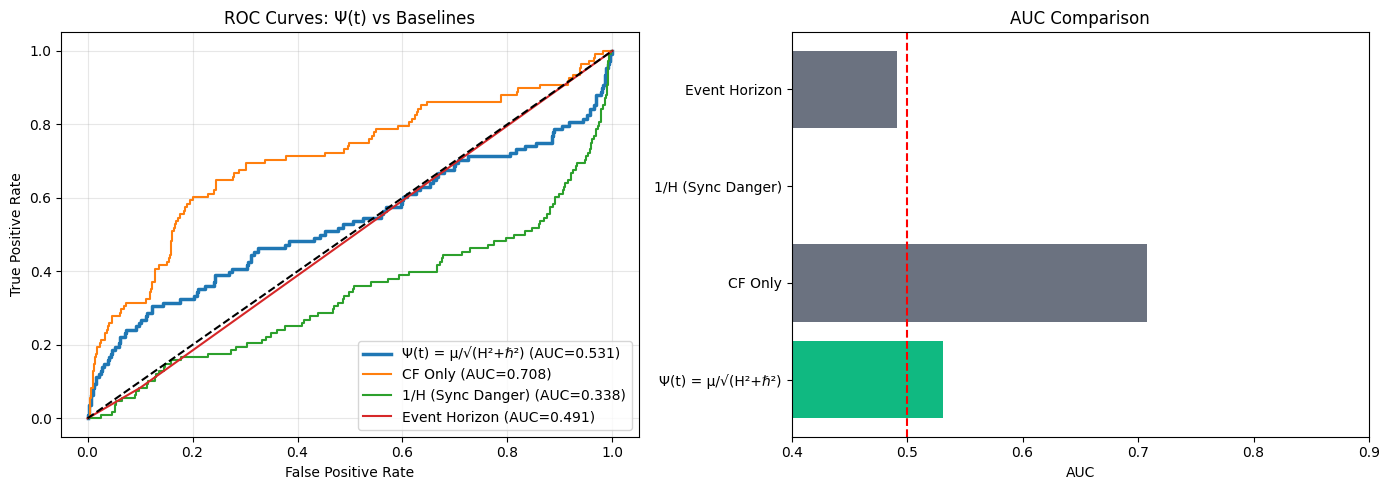


=== AUC Results ===
CF Only                  : 0.708
Ψ(t) = μ/√(H²+ℏ²)        : 0.531
Event Horizon            : 0.491
1/H (Sync Danger)        : 0.338


In [ ]:
# === ROC/AUC VALIDATION ===

# Crisis labels
def create_labels(index, crises, pre=20, post=10):
    labels = pd.Series(0, index=index)
    for name, date in crises.items():
        start = date - pd.Timedelta(days=pre)
        end = date + pd.Timedelta(days=post)
        labels[(labels.index >= start) & (labels.index <= end)] = 1
    return labels

y_true_initial = create_labels(IFI_v3_norm.index, CRISES)

# Baselines
cf_aligned = CF.loc[IFI_v3_norm.index]
cf_norm = (cf_aligned - cf_aligned.min()) / (cf_aligned.max() - cf_aligned.min())

inverse_H = 1 / H_TOTAL
inverse_H_norm = (inverse_H - inverse_H.min()) / (inverse_H.max() - inverse_H.min())

models = {
    'Ψ(t) = μ/√(H²+ℏ²)': IFI_v3_norm,
    'CF Only': cf_norm,
    '1/H (Sync Danger)': inverse_H_norm,
    'Event Horizon': INSIDE_HORIZON.astype(float)
}

# ROC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
auc_results = {}
for name, score in models.items():
    # Drop NaNs from the score and align y_true accordingly
    # First, get a combined series to identify NaNs across score and y_true
    combined = pd.concat([score, y_true_initial], axis=1).dropna()
    y_true_cleaned = combined.iloc[:, 1]
    score_cleaned = combined.iloc[:, 0]

    # Handle cases where score_cleaned might be empty after dropping NaNs
    if len(score_cleaned) > 1 and y_true_cleaned.nunique() > 1: # need at least two classes for roc_curve
        fpr, tpr, _ = roc_curve(y_true_cleaned, score_cleaned)
        roc_auc = auc(fpr, tpr)
        auc_results[name] = roc_auc
        lw = 2.5 if 'Ψ' in name else 1.5
        ax1.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})', linewidth=lw)
    else:
        print(f"Skipping ROC for '{name}' due to insufficient data or single class after NaN removal.")
        auc_results[name] = np.nan # Assign NaN to AUC for skipped models

ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves: Ψ(t) vs Baselines')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# AUC bar
ax2 = axes[1]
# Filter out NaN AUC results for plotting
plot_auc_results = {k: v for k, v in auc_results.items() if not np.isnan(v)}
colors = ['#10b981' if 'Ψ' in k else '#6b7280' for k in plot_auc_results.keys()]
ax2.barh(list(plot_auc_results.keys()), list(plot_auc_results.values()), color=colors)
ax2.axvline(0.5, color='red', linestyle='--', label='Random')
ax2.set_xlabel('AUC')
ax2.set_xlim(0.4, 0.9)
ax2.set_title('AUC Comparison')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Caria/great_caria_v31_roc.png', dpi=150)
plt.show()

print('\n=== AUC Results ===')
for name, score in sorted(auc_results.items(), key=lambda x: (-x[1] if not np.isnan(x[1]) else float('-inf'))):
    print(f'{name:25s}: {score:.3f}')

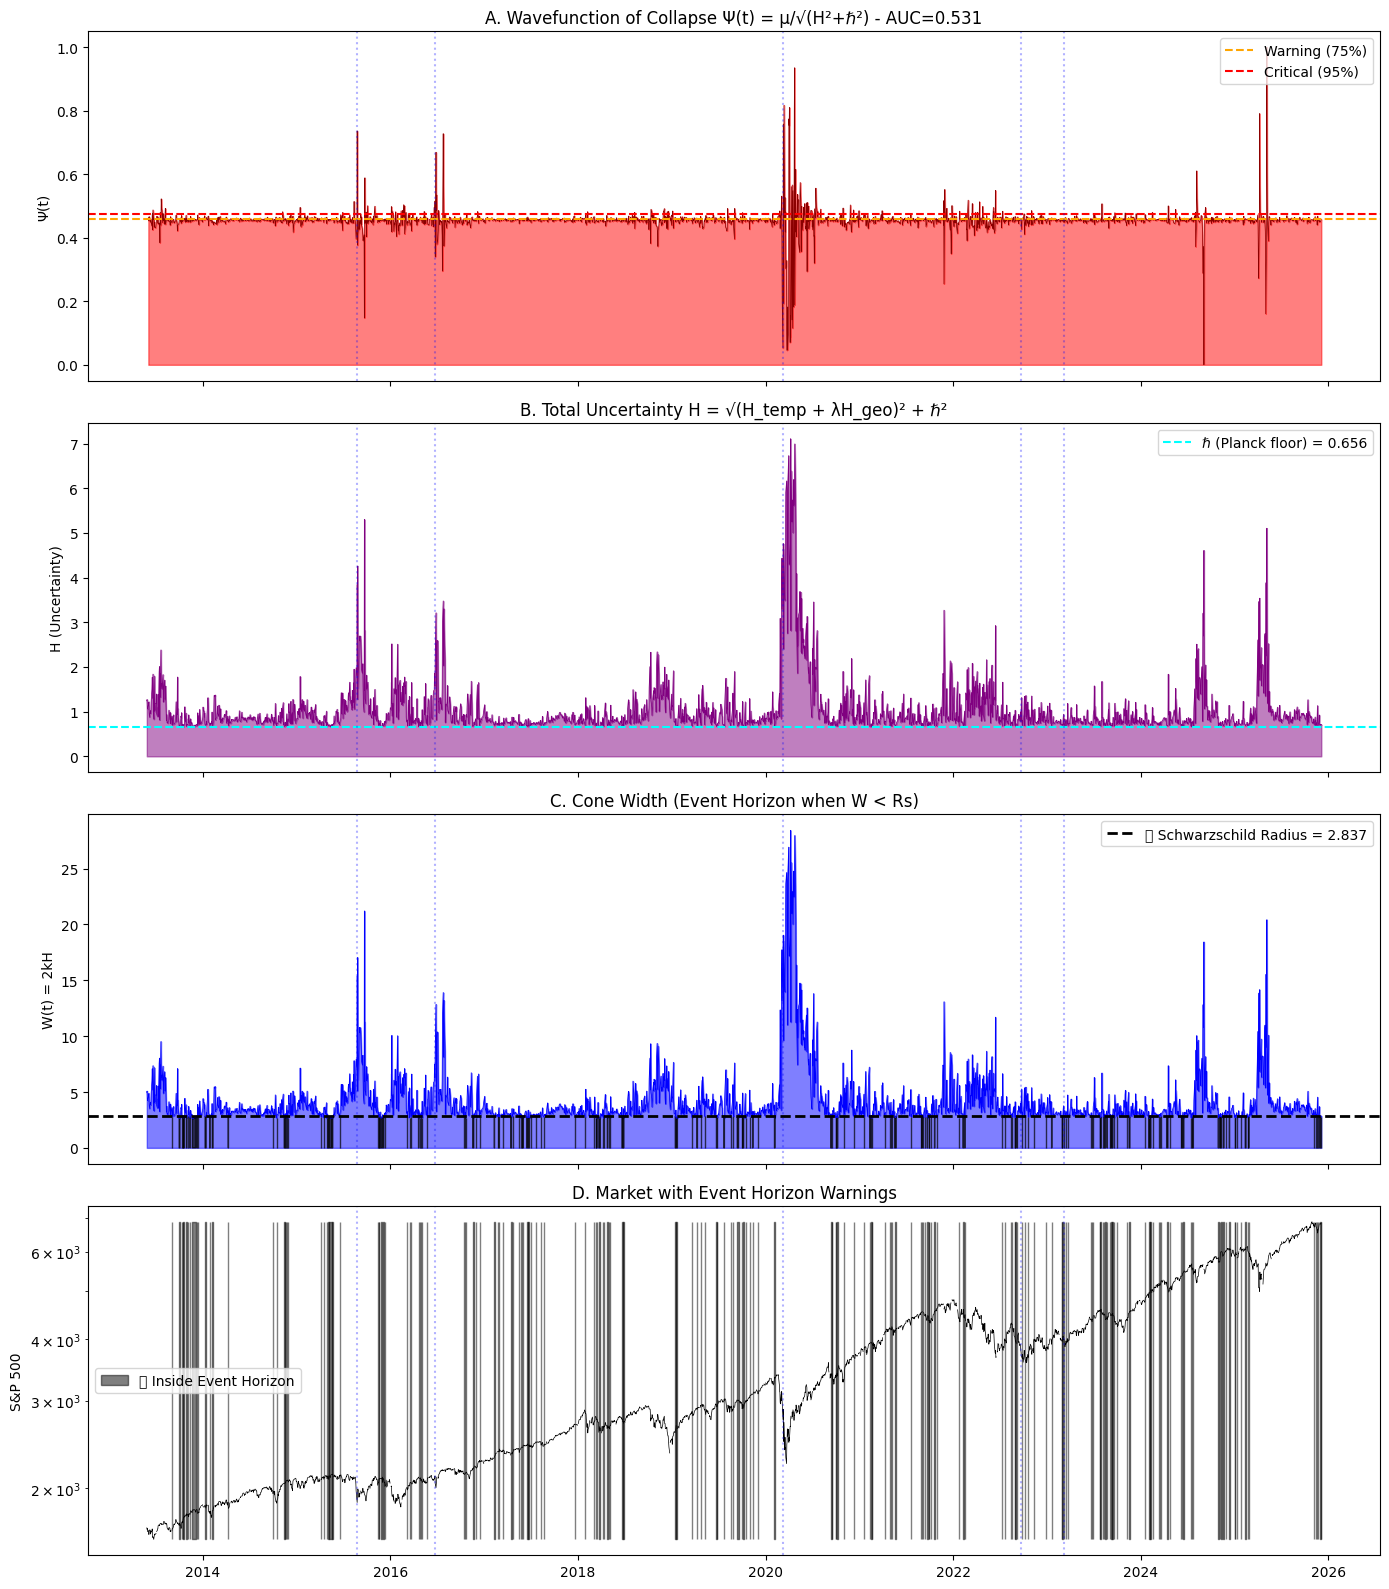

In [ ]:
# === FINAL SUMMARY VISUALIZATION ===
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# A. Ψ(t) - The Wavefunction
ax1 = axes[0]
ax1.fill_between(IFI_v3_norm.index, IFI_v3_norm.values, alpha=0.5, color='red')
ax1.plot(IFI_v3_norm.index, IFI_v3_norm.values, 'darkred', linewidth=0.5)
ax1.axhline(IFI_v3_norm.quantile(0.75), color='orange', linestyle='--', label='Warning (75%)')
ax1.axhline(IFI_v3_norm.quantile(0.95), color='red', linestyle='--', label='Critical (95%)')
ax1.set_ylabel('Ψ(t)')
ax1.set_title(f'A. Wavefunction of Collapse Ψ(t) = μ/√(H²+ℏ²) - AUC={auc_results.get("Ψ(t) = μ/√(H²+ℏ²)", 0):.3f}')
ax1.legend(loc='upper right')

# B. H_total with Planck floor
ax2 = axes[1]
ax2.fill_between(H_TOTAL.index, H_TOTAL.values, alpha=0.5, color='purple')
ax2.plot(H_TOTAL.index, H_TOTAL.values, 'purple', linewidth=0.5)
ax2.axhline(h_bar_scaled, color='cyan', linestyle='--', label=f'ℏ (Planck floor) = {h_bar_scaled:.3f}')
ax2.set_ylabel('H (Uncertainty)')
ax2.set_title('B. Total Uncertainty H = √(H_temp + λH_geo)² + ℏ²')
ax2.legend()

# C. Cone Width with Schwarzschild Radius
ax3 = axes[2]
ax3.fill_between(CONE_WIDTH.index, CONE_WIDTH.values, alpha=0.5, color='blue')
ax3.plot(CONE_WIDTH.index, CONE_WIDTH.values, 'blue', linewidth=0.5)
ax3.axhline(SCHWARZSCHILD, color='black', linewidth=2, linestyle='--', label=f'🕳️ Schwarzschild Radius = {SCHWARZSCHILD:.3f}')
ax3.fill_between(CONE_WIDTH.index, 0, CONE_WIDTH.values,
                 where=CONE_WIDTH < SCHWARZSCHILD, alpha=0.7, color='black')
ax3.set_ylabel('W(t) = 2kH')
ax3.set_title('C. Cone Width (Event Horizon when W < Rs)')
ax3.legend()

# D. S&P 500 with Event Horizon warnings
ax4 = axes[3]
if 'USA_index' in df.columns:
    sp500 = df['USA_index'].loc[common_idx]
    ax4.plot(sp500.index, sp500.values, 'k-', linewidth=0.5)

    # Event horizons (black holes)
    ax4.fill_between(sp500.index, sp500.min(), sp500.max(),
                     where=INSIDE_HORIZON, alpha=0.5, color='black',
                     label='🕳️ Inside Event Horizon')

ax4.set_ylabel('S&P 500')
ax4.set_title('D. Market with Event Horizon Warnings')
ax4.set_yscale('log')
ax4.legend()

# Crisis markers
for ax in axes:
    for name, date in CRISES.items():
        if date > common_idx.min() and date < common_idx.max():
            ax.axvline(date, color='blue', alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Caria/great_caria_v31_final.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
# === EXPORT ===
import json
from datetime import datetime

current = {
    'psi': float(PSI_norm.iloc[-1]),
    'mu': float(mu_aligned.iloc[-1]),
    'H_total': float(H_TOTAL.iloc[-1]),
    'cone_width': float(CONE_WIDTH.iloc[-1]),
    'inside_horizon': bool(INSIDE_HORIZON.iloc[-1]),
    'spin': float(SPIN.iloc[-1]) if not pd.isna(SPIN.iloc[-1]) else 0
}

if current['psi'] >= PSI_norm.quantile(0.95):
    status = 'CRITICAL'
elif current['psi'] >= PSI_norm.quantile(0.75) or current['inside_horizon']:
    status = 'WARNING'
else:
    status = 'STABLE'

export = {
    'version': 'Great Caria v3.1 (General Financial Relativity)',
    'generated': datetime.now().isoformat(),
    'equation': 'Ψ(t) = μ / √(H² + ℏ²)',
    'status': status,
    'current': current,
    'constants': {
        'h_bar': float(h_bar_scaled),
        'schwarzschild_radius': float(SCHWARZSCHILD),
        'lambda_geo': LAMBDA
    },
    'thresholds': {
        'warning': float(PSI_norm.quantile(0.75)),
        'critical': float(PSI_norm.quantile(0.95))
    },
    'auc_scores': auc_results,
    'physics': {
        'h_bar_meaning': 'Minimum market quantum blur (irreducible volatility)',
        'spin_meaning': 'G7 instability is more dangerous than EM instability',
        'event_horizon': 'When cone width < Schwarzschild radius, no escape'
    }
}

with open('/content/drive/MyDrive/Caria/great_caria_v31.json', 'w') as f:
    json.dump(export, f, indent=2)

print('\n' + '='*70)
print('GREAT CARIA v3.1 - FINAL SUMMARY')
print('='*70)
print(json.dumps(export, indent=2))